In this notebook, we go through feature importance analysis. Feature importance analysis is useful tool to find and validate statistical edges. Although p-value has been widely used to validate some staistical patterns, it has the follwing caveates:

1. Relying on the strong assumption
2. In the existence of highly multi collinear model, p-value cannot be robust
3. Estimating parameter value probability rather than probability of the null hypothesis in general
4. Significance at in-sample

The first caveat implies that the model assumes linear model with gaussian noise, which is not always the case in real world problems. The second caveat states that tranditional regression model cannot discriminate among redundant variables, leading to substitution effects between related p-values. Third caveat comes from the fact that p-value estimate probability of empirically estimated parameter being greater than estimated parameter, subjected to null hypothesis. Thus, they do not provide the probabilty of null hypothesis being true. The fourth caveat is that p-values estimate significance at in-sample. Multiple testing inflates estimated p-values and leads to p-hacking.

We introduce alternative way, feature importance, which solves these caveates.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

We use an artificially generated classification problem. Data has some informative, redandant, and noise features.

In [2]:
from finance_ml.experiments import get_classification_data

X,y = get_classification_data(40, 5, 30, 10000, sigma=0.1)
print(X.shape)
print(X.head())
print(f"columns={X.columns.tolist()}")

(10000, 40)
        I_0       I_1       I_2       I_3       I_4       N_0       N_1  \
0  2.105359  2.861661  0.104159  0.686149  1.369429 -0.868903 -1.297125   
1 -0.330754  1.464379 -1.405119  0.396713 -1.722305  0.471952 -1.443687   
2 -0.461334 -0.160432 -2.169501 -0.137535  0.398229 -0.278979 -1.860566   
3 -1.573667  3.110105  0.073939  1.232501  1.069429  0.700720 -1.097145   
4  0.528677  1.538982 -1.603758  2.056413  0.777722 -0.644594 -0.304476   

        N_2       N_3       N_4  ...      R_20      R_21      R_22      R_23  \
0 -0.160205 -0.481024  0.841338  ...  2.349950  0.166769  0.380488  2.693087   
1 -0.433773  0.123114 -0.102970  ... -0.387650 -1.457474 -1.381808  1.461375   
2  0.909540 -0.396742  2.455228  ... -0.415860 -2.050442 -2.266655 -0.104174   
3  0.157145 -1.699373  1.167458  ... -1.524246  0.169084  0.130410  3.068232   
4  0.682256 -0.644368  0.280994  ...  0.517340 -1.628636 -1.762587  1.535581   

       R_24      R_25      R_26      R_27      R_28     

Each feature is named as the follings:
1. I_\*: informative feature
2. R_\*: redandant feature. The information is shared with some I_\*
3. N_\*: noise feature. No predictive power is contained

# Mean-Decrease Impurity (MDI)

MDI is feature importance is subproducts of decision tree learning process.
At each node t splitting with feature f, a tree maximize imprutiy gain

$$ \Delta g[t, f] = i[t] - (\frac{N^0}{N} i[t^0] +\frac{N^1}{N} i[t^1])$$

where $N^0$ and $N^1$ are the number of samples of left and right node. $i[t^0]$ and $i[t^1]$ are impurity of left and right node.

This impurities are aggregated across nodes with weighted average. The value is bounded at [0, 1] and all added up to 1. The non-important value is expected to be around 1/F where F features exist.

         mean       std
I_0  0.020182  0.000394
I_1  0.059066  0.001600
I_2  0.024347  0.000582
I_3  0.017143  0.000186
I_4  0.030110  0.000838
1/F = 0.025


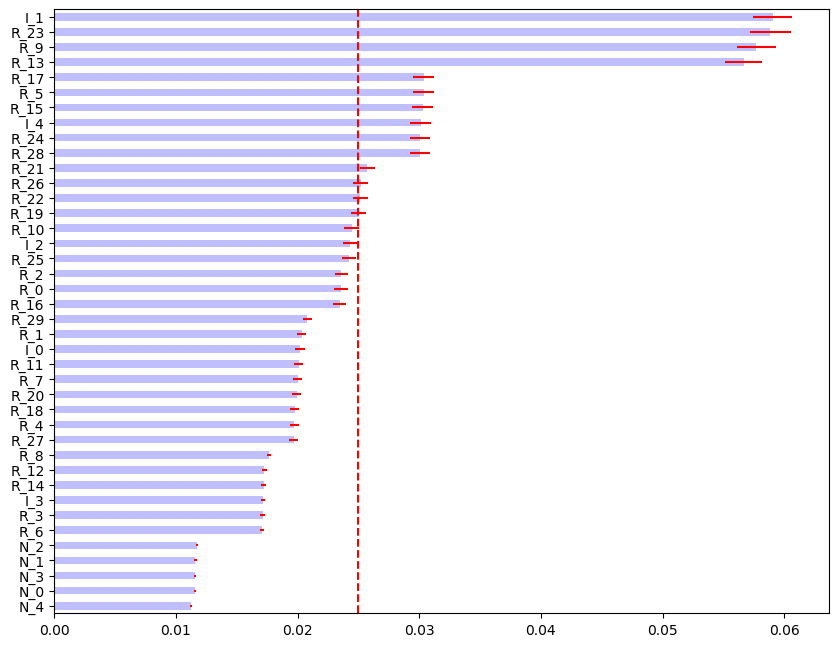

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

from finance_ml.importance import feat_imp_mdi


clf = DecisionTreeClassifier(criterion="entropy", max_features=1, class_weight="balanced", min_weight_fraction_leaf=0)
clf = BaggingClassifier(base_estimator=clf, n_estimators=1000, max_features=1., max_samples=1., oob_score=False)
clf.fit(X, y);
imp = feat_imp_mdi(clf, X.columns)
print(imp.head())
imp.sort_values('mean', inplace=True)
plt.figure(figsize=(10, imp.shape[0] / 5));
F = X.shape[1]
print(f"1/F = {1./F}")
plt.axvline(x=1./F, linestyle='dashed', color='r');
imp['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=imp['std'], error_kw={'ecolor': 'r'});

MDI does a good job. Nonnoisy features are ranked higher than noise ones. Due to substitution effects, some nonnoisy features appear to be much more important than the others. If some features share the information of other features, they might not be necessary to use.

MDI solves three out of four caveates, 1-3. First, trees do not assume any specific algebraic formula. Second, ensemble of tress reduce variance of the model. Lastly, MDI estimates usefulness of the feature in general. As in last caveat, MDI is , however, still estimated at in-sample.

# Mean-Decrease Accuracy (MDA)

To combat caveate 4, we introduce MDA, which estimates importance using cross validation. For each round, one of the features are shuffled one by one and see the difference from the original performance. This value is not bounded. 

         mean       std
I_0  0.018588  0.019644
I_1  0.066651  0.025270
I_2  0.016271  0.025279
I_3  0.030782  0.005429
I_4  0.026361  0.012088


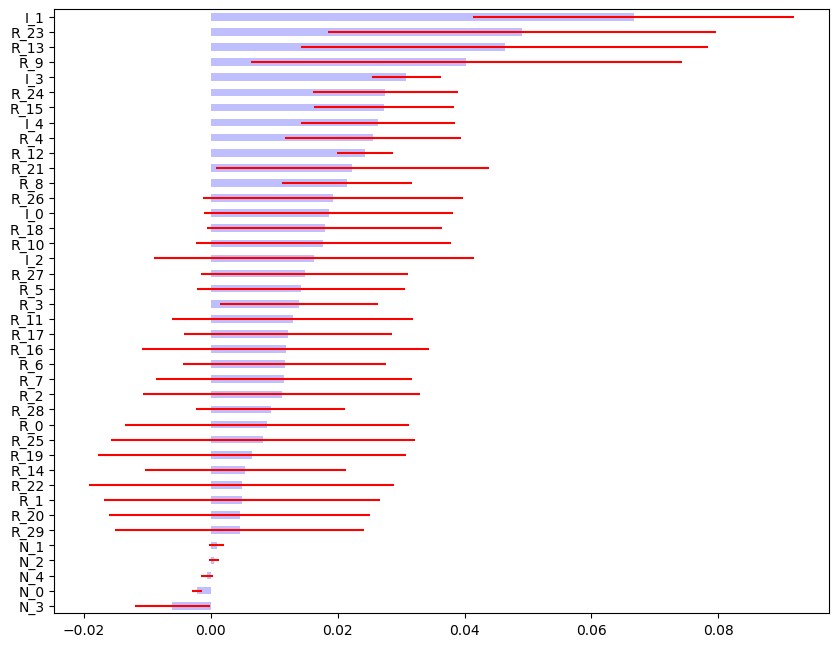

In [4]:
from finance_ml.importance import feat_imp_mda

clf = DecisionTreeClassifier(criterion="entropy", max_features=1, class_weight="balanced", min_weight_fraction_leaf=0)
clf = BaggingClassifier(base_estimator=clf, n_estimators=100, max_features=1., max_samples=1., oob_score=False, n_jobs=8)
imp = feat_imp_mda(clf, X, y)
print(imp.head())
imp.sort_values('mean', inplace=True)
plt.figure(figsize=(10, imp.shape[0] / 5))
imp['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=imp['std'], error_kw={'ecolor': 'r'});

This method can use any scores in general. One thin you have to care about is substitution effects. In the extreme case, you have two identical features. One of them is shuffeled, the accuracy may not change. Thus, feature importance is zero.

# Substitution Effects

When more than one features share the same predictive information, substitution effects can bias the reslts from features importance methods. In the case of MDI, the importance would be halved.

In order to deal with this, we have two methods:
1. Orthogonalization: Generate PCA components features and estimate importances on them
2. Clustering Features: Cluster features and estimate importance of clusters

The method 1, may reduce the substitution effects, but it has three caveates:
1. non linear relation redandant features still cause substitution effects
2. May not have intuititve explanation
3. Defined by eigen vectors, which may not necessary maximize the output


Let's look at clustering feature importance.

For clustering method, it involves the two steps:
1. Features Clustering
2. Clustered Importance

For step1, you can utilize ONC algorithm(`finance_ml/clustering.py`). In this step, you can check the quality of clustering based on silhouette scores. If the scores is not good, one feature may contain information across multiple clusters. you can use the following altgorithms:

$$X_{n, i} = \alpha_i + \sum_{j \in \cup_{l < k} D_l} \beta_{i, j} X_{n, j} + \epsilon_{n, i} \forall i \in D_k$$

For each cluster, you regress on the the ohter cluster. Then you can use residual instead.

In the step2, we estiamte importance of each cluster rather than individual features.

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

def group_mean_std(df0, clstrs):
    out = pd.DataFrame(columns=['mean', 'std'])
    for key, elements in clstrs.items():
        df1 = df0[elements].sum(axis=1)
        out.loc[f"C_{key}", 'mean'] = df1.mean()
        out.loc[f"C_{key}", 'std'] = df1.std() * df1.shape[0]**-.5
    return out

def feat_imp_mdi_clustered(fit, featNames, clstrs):
    df0 = {i:tree.feature_importances_ for i, tree in enumerate(fit.estimators_)}
    df0 = pd.DataFrame.from_dict(df0, orient='index')
    df0.columns = featNames
    df0 = df0.replace(0, np.nan) #because max_features=1
    imp = group_mean_std(df0, clstrs)
    imp /= imp['mean'].sum()
    return imp

def feat_imp_mda_clustered(clf, X, y, clstrs, n_splits=10):
    cv_gen = KFold(n_splits=n_splits)
    scr0 = pd.Series()
    scr1 = pd.DataFrame(columns=clstrs.keys())
    for i, (train, test) in enumerate(cv_gen.split(X=X)):
        X0, y0 = X.iloc[train, :], y.iloc[train]
        X1, y1 = X.iloc[test, :], y.iloc[test]
        fit = clf.fit(X=X0, y=y0)
        prob = fit.predict_proba(X1)
        scr0.loc[i] = -log_loss(y1, prob, labels=clf.classes_)
        for j in scr1.columns:
            X1_ = X1.copy(deep=True)
            for k in clstrs[j]:
                np.random.shuffle(X1_[k].values)
            prob = fit.predict_proba(X1_)
            scr1.loc[i, j] = -log_loss(y1, prob, labels=clf.classes_)
    imp = (-1 * scr1).add(scr0, axis=0)
    imp = imp / (-1 * scr1)
    imp = pd.concat({'mean': imp.mean(), 'std': imp.std() * imp.shape[0] ** -0.5}, axis=1)
    imp.index = [f"C_{i}" for i in imp.index]
    return imp

{0: ['I_0', 'R_1', 'R_4', 'R_7', 'R_11', 'R_18', 'R_20', 'R_27', 'R_29'], 1: ['I_1', 'R_9', 'R_13', 'R_23'], 2: ['I_2', 'R_0', 'R_2', 'R_10', 'R_16', 'R_19', 'R_21', 'R_22', 'R_25', 'R_26'], 3: ['I_3', 'R_3', 'R_6', 'R_8', 'R_12', 'R_14'], 4: ['I_4', 'R_5', 'R_15', 'R_17', 'R_24', 'R_28'], 5: ['N_0', 'N_1', 'N_2', 'N_3', 'N_4']}


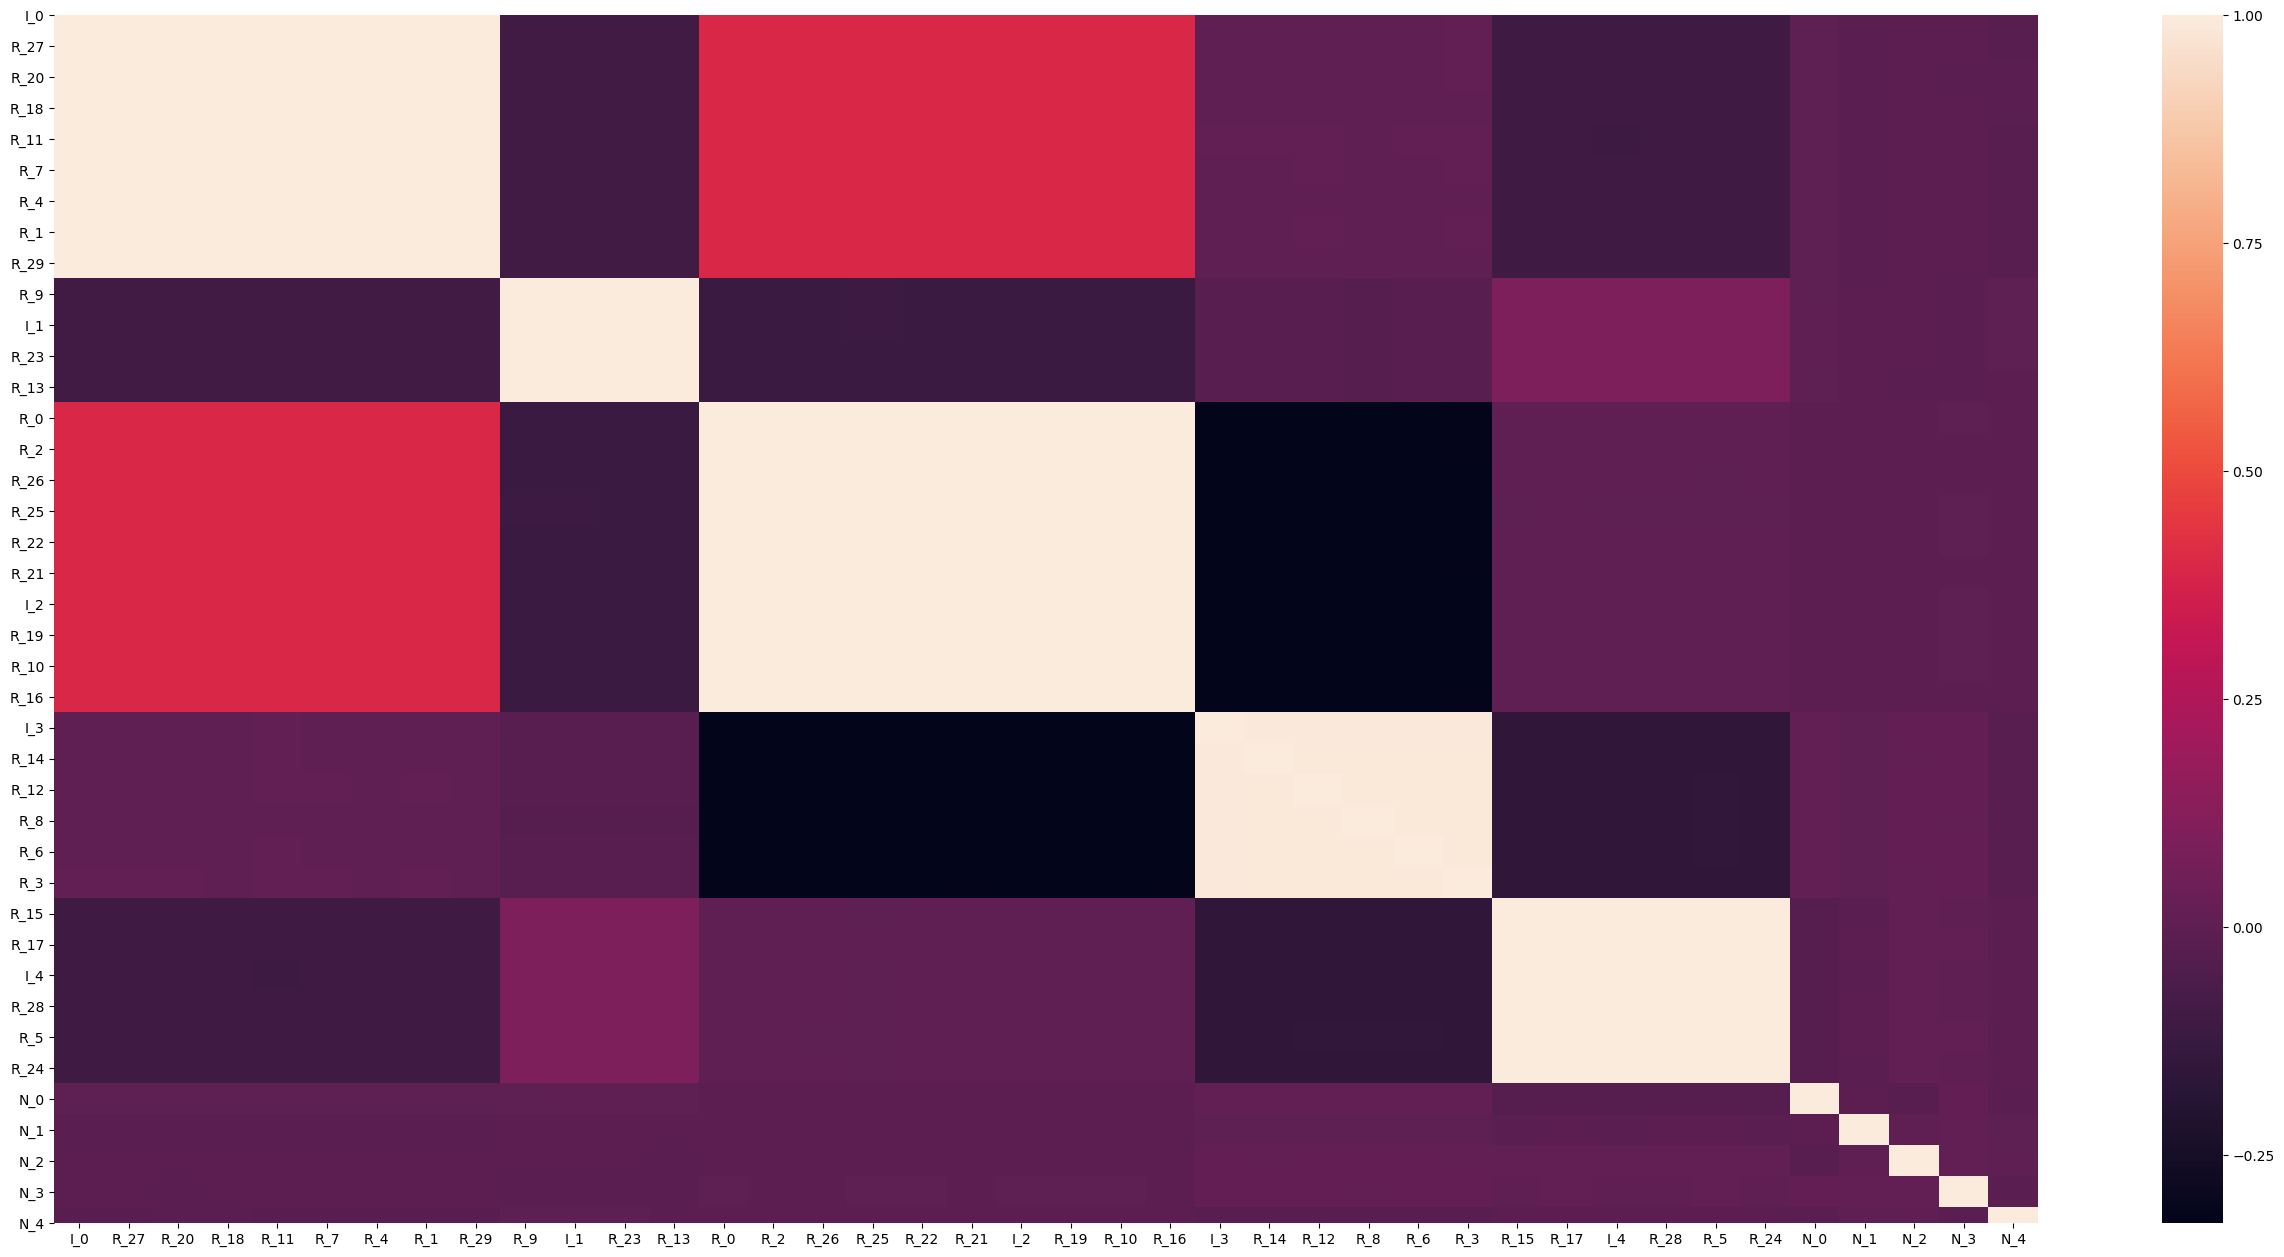

In [7]:
from finance_ml.clustering import cluster_kmeans_base

corr0, clstrs, silh = cluster_kmeans_base(X.corr(), max_num_clusters=10, n_init=20)
print(clstrs)
sns.heatmap(corr0);

In this clustering, one of the cluster contains noise features.

         mean         std
C_0  0.179863  0.00203763
C_1  0.233603  0.00441887
C_2  0.242849  0.00226746
C_3  0.102861  0.00144938
C_4  0.182585  0.00253707


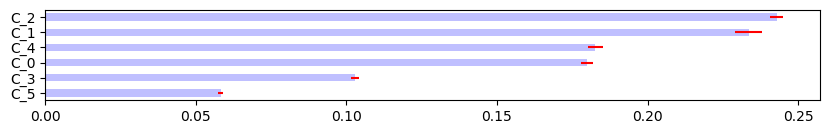

In [10]:
from finance_ml.importance import feat_imp_mdi_clustered

clf = DecisionTreeClassifier(criterion="entropy", max_features=1, class_weight="balanced", min_weight_fraction_leaf=0)
clf = BaggingClassifier(base_estimator=clf, n_estimators=100, max_features=1., max_samples=1., oob_score=False)
clf = clf.fit(X, y)
imp = feat_imp_mdi_clustered(clf, X.columns, clstrs)
print(imp.head())
imp.sort_values('mean', inplace=True)
plt.figure(figsize=(10, imp.shape[0] / 5))
imp['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=imp['std'], error_kw={'ecolor': 'r'})

         mean       std
C_0  0.171602  0.042944
C_1  0.235106  0.067768
C_2  0.244950  0.062507
C_3  0.160570  0.021117
C_4  0.150829  0.042221


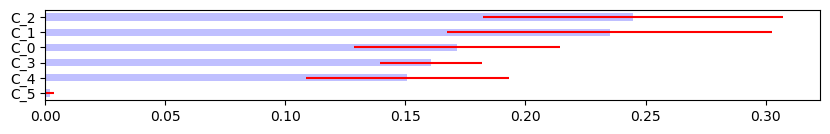

In [12]:
from finance_ml.importance import feat_imp_mda_clustered


clf = DecisionTreeClassifier(criterion="entropy", max_features=1, class_weight="balanced", min_weight_fraction_leaf=0)
clf = BaggingClassifier(base_estimator=clf, n_estimators=100, max_features=1., max_samples=1., oob_score=False)
imp = feat_imp_mda_clustered(clf, X, y, clstrs, n_splits=10)
print(imp.head())
imp.sort_values('mean', inplace=True)
plt.figure(figsize=(10, imp.shape[0] / 5))
imp['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=imp['std'], error_kw={'ecolor': 'r'})